In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

In [2]:
OPERATION = 'addition'
assert OPERATION in ['addition', 'multiplication']



In [3]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'
# full_model_name = 'EleutherAI/pythia-6.9b'
#full_model_name = 'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
remote = False
datapath = f'llm-addition/experimentation'


In [4]:
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
NLAYERS = model.config.num_hidden_layers



Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [5]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

def get_nums_hss_solo(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    activations.append(hs[:,-1].save())
    act = torch.stack(activations).detach().cpu()
    act = act.transpose(0, 1)
    return nums, act


In [13]:
mina = 1
maxa = 360
layer = 3
a, hss = get_nums_hss_solo( mina, maxa)
# Filter out zeros, they cannot be used with log
mask = (a != 0)
hss = hss[mask]
a = a[mask]

In [14]:
#Attempt linear fit vs full hidden state

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy())
# print("coef", model.coef_)
# print("intercept", model.intercept_)
# print("r2 score", model.score(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy()))
# print("predicted", model.predict(hss[:,layer,:].cpu().float().numpy()))
# from sklearn.metrics import r2_score
# y_true = a.cpu().float().numpy()
# y_pred = model.predict(hss[:,layer,:].cpu().float().numpy())
# r2 = r2_score(y_true, y_pred)
# print("R2 score of the model: ", r2)

# Right... this is useless as with 4096 dim hiddeen state, you can regress anything perfectly. Hence PCA. Let's try that...


In [15]:
# PCA decompose and attempt fit against each of them

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

npca = 20


hs = hss[:, layer, :].cpu().float().numpy()
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

pca = PCA(n_components=npca)
tf = pca.fit_transform(hs_scaled)
# print("explained_variance_ratio", pca.explained_variance_ratio_)
# print("explained_variance", pca.explained_variance_)
# print("singular_values", pca.singular_values_)
# print("components", pca.components_)
for i in range(npca):
    lr = LinearRegression()
    x = np.log(a)[:, None]
    y = tf[:,i]
    lr.fit(x, y)
    # print("coef", i, model.coef_)
    # print("intercept", i, model.intercept_)
    print("r2 score", i, lr.score(x, y))
    # print("predicted", i, model.predict(x))



r2 score 0 0.025526294201860922
r2 score 1 0.6933745608490499
r2 score 2 0.12224810180302881
r2 score 3 0.011895248293967375
r2 score 4 0.0004587105813146364
r2 score 5 0.02753877684855699
r2 score 6 0.006442388034862412
r2 score 7 0.027741200256286458
r2 score 8 0.008806326085912919
r2 score 9 0.004710520371204452
r2 score 10 0.010718199145637541
r2 score 11 0.006792608256089294
r2 score 12 0.012985393314891458
r2 score 13 0.004003498497106128
r2 score 14 8.262193366570525e-05
r2 score 15 0.0002487279160771072
r2 score 16 3.756723380232696e-05
r2 score 17 0.004783029433551245
r2 score 18 1.9646150386076755e-05
r2 score 19 6.002079810940586e-08


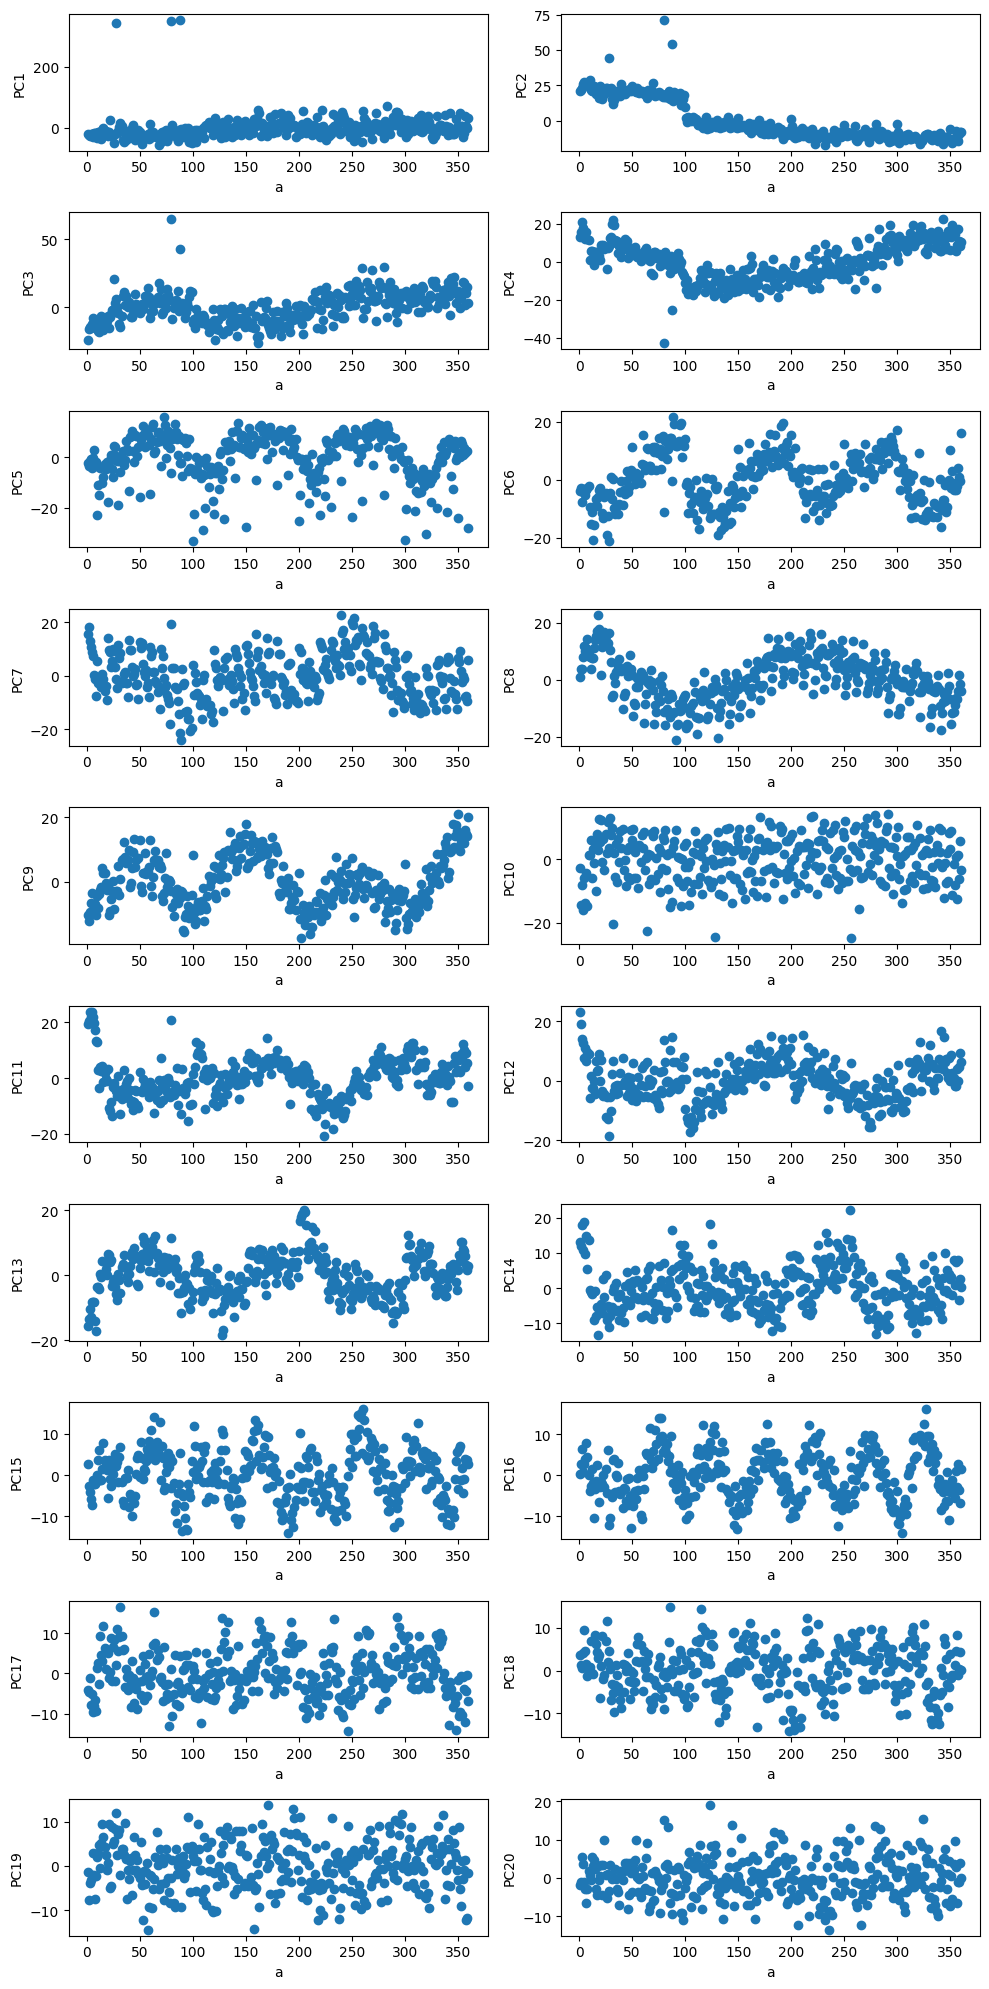

In [34]:
# Plot principal components

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(20):
    x = a[rng]
    # x = np.log(a[rng] / 50)
    axs[i].scatter(x, (tf[:, i][rng]))
    axs[i].set_xlabel('a')
    axs[i].set_ylabel(f'PC{i+1}')
plt.tight_layout()
plt.show()

100%|██████████| 300/300 [00:00<00:00, 863.29it/s]


linear r2 score 0.22001812379547458 229.09108562315973
log r2 score 0.3316380886933211 5.834288639055789
log is better


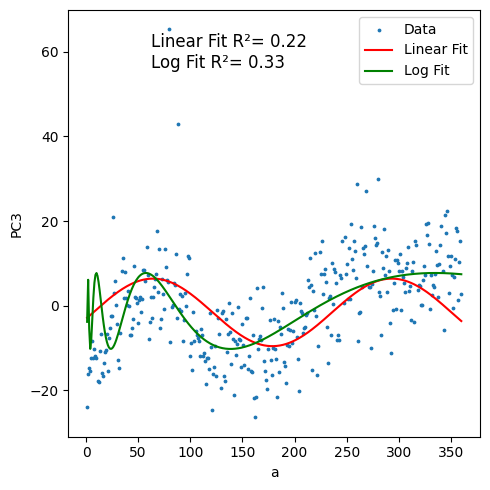

In [86]:
# Fits a given component to a sine wave.

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)

component = 2
y = tf[:, component]

def fit(period, is_log):
    if is_log:
        t = np.log(a)
        sina = np.sin(t / np.log(period) * 2*np.pi)
        cosa = np.cos(t / np.log(period) * 2*np.pi)
    else:
        t = a/period
        sina = np.sin(t * 2*np.pi)
        cosa = np.cos(t * 2*np.pi)

    X = np.stack([sina, cosa], axis = 1)

    lr = LinearRegression()
    
    lr.fit(X, y)
    r2 = lr.score(X, y)

    y_pred = lr.predict(X)

    return r2, lr, y_pred, period

def best_fit(periods, is_log):
    results = [fit(period, is_log) for period in tqdm(periods)]
    best = max(results, key=lambda x: x[0])
    return best

best_linear = best_fit(np.logspace(np.log10(50), np.log10(300), 300), False)
best_log = best_fit(np.logspace(np.log10(1.001), np.log10(10), 300), True)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs = axs

axs.scatter(a, y, s=3)
axs.plot(a, best_linear[2], color='red')
axs.plot(a, best_log[2], color='green')
axs.set_xlabel('a')
axs.set_ylabel(f'PC{component+1}')
plt.tight_layout()
print("linear r2 score", best_linear[0], best_linear[3])
print("log r2 score", best_log[0], best_log[3])
print("log is better" if best_log[0] > best_linear[0] else "linear is better")
plt.legend(['Data', 'Linear Fit', 'Log Fit'])
plt.text(0.2, 0.9, f'Linear Fit R²= {best_linear[0]:.2f}\nLog Fit R²= {best_log[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=axs.transAxes, fontsize=12)

plt.show()

# LOG is better: PC3




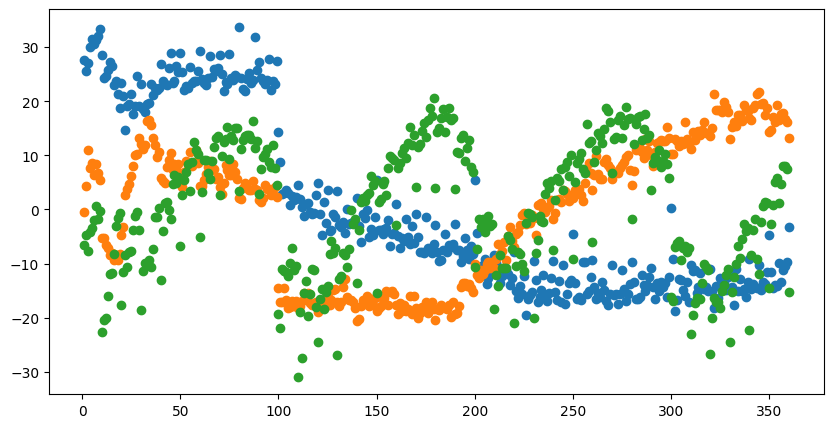

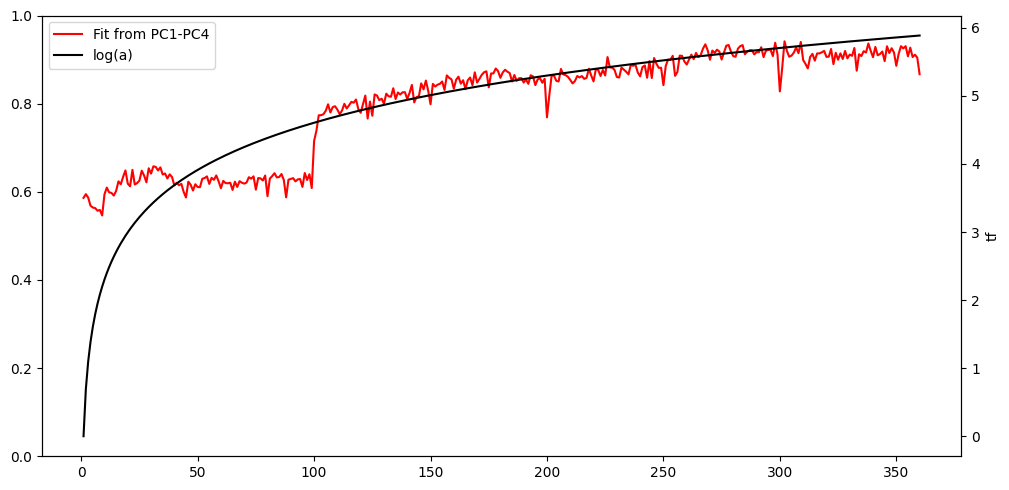

r2 score of lr: 0.7652744291569786
coefficients of lr: [-0.04727586  0.00084248  0.00170399 -0.          0.         -0.01123321
  0.         -0.          0.          0.        ]


In [11]:
# Fit PC to logarithm.
# I played with components and alpha and it never plausibly recovered a fit.
components = slice(0, 10)
from sklearn.linear_model import Lasso
lr = Lasso(alpha=1)
# lr = LinearRegression()

lr.fit(tf[:, components], np.log(a))
plt.figure(figsize=(10, 5))
plt.scatter(a, tf[:, 0], label='PC1')
plt.scatter(a, tf[:, 1], label='PC2')
plt.scatter(a, tf[:, 2], label='PC3')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
# ax1.scatter(a, tf[:, 0], label='PC1')
# ax1.scatter(a, tf[:, 1], label='PC2')
ax2.plot(a, lr.predict(tf[:, components]), color='red', label='Fit from PC1-PC4')
ax2.plot(a, np.log(a), color='black', label='log(a)')
plt.tight_layout()
plt.xlabel('a')
plt.ylabel('tf')
plt.legend()
plt.show()
print("r2 score of lr:", lr.score(tf[:, components], np.log(a)))
print("coefficients of lr:", lr.coef_)



In [12]:
def check_tokenization(mina, maxa):
    "Check range of values is safe for the one-token assumption. More precise than the original paper."
    for a in range(mina, maxa+1):
        for b in range(mina, maxa+1):
            if OPERATION == "addition":
                text = f"{a}+{b}="
            else:
                text = f"{a}*{b}="
            tokens = model.tokenizer.tokenize(text)
            assert len(tokens) == 4, tokens
check_tokenization(0, 520)